# Деревья решений

## Решение задачи классификации

In [68]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Создаём сложный датасет
X, y = make_classification(
    n_samples=1000,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_classes=4,
    n_clusters_per_class=1,
    class_sep=0.5,
    random_state=42
)

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Инициализация дерева
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)
print(f"Accuracy: {clf.score(X_test, y_test):.2f}")

Accuracy: 0.66


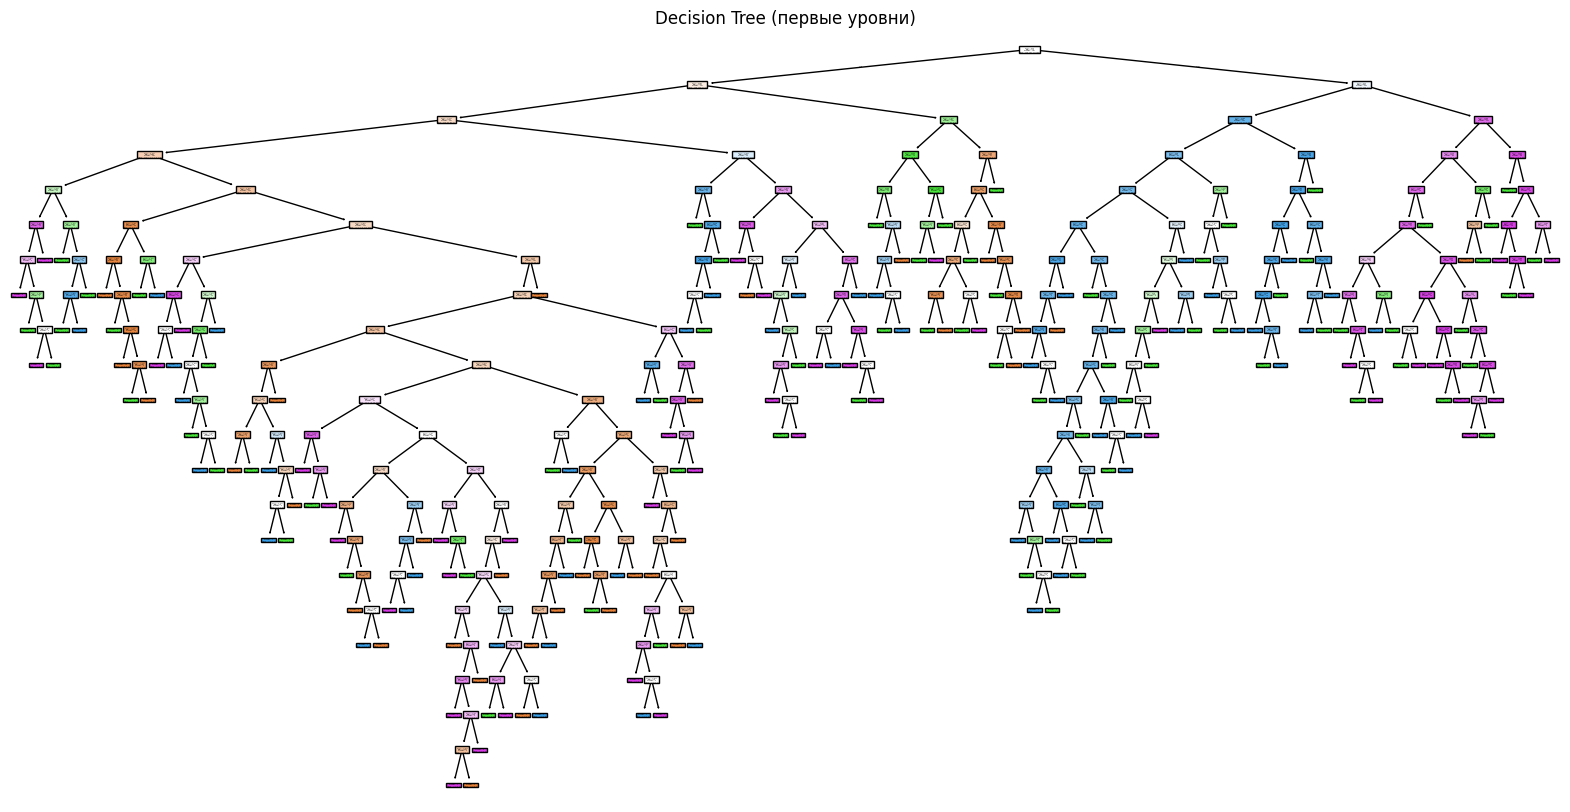

In [24]:
plt.figure(figsize=(20, 10))
plot_tree(clf, filled=True)
plt.title("Decision Tree (первые уровни)")
plt.show()

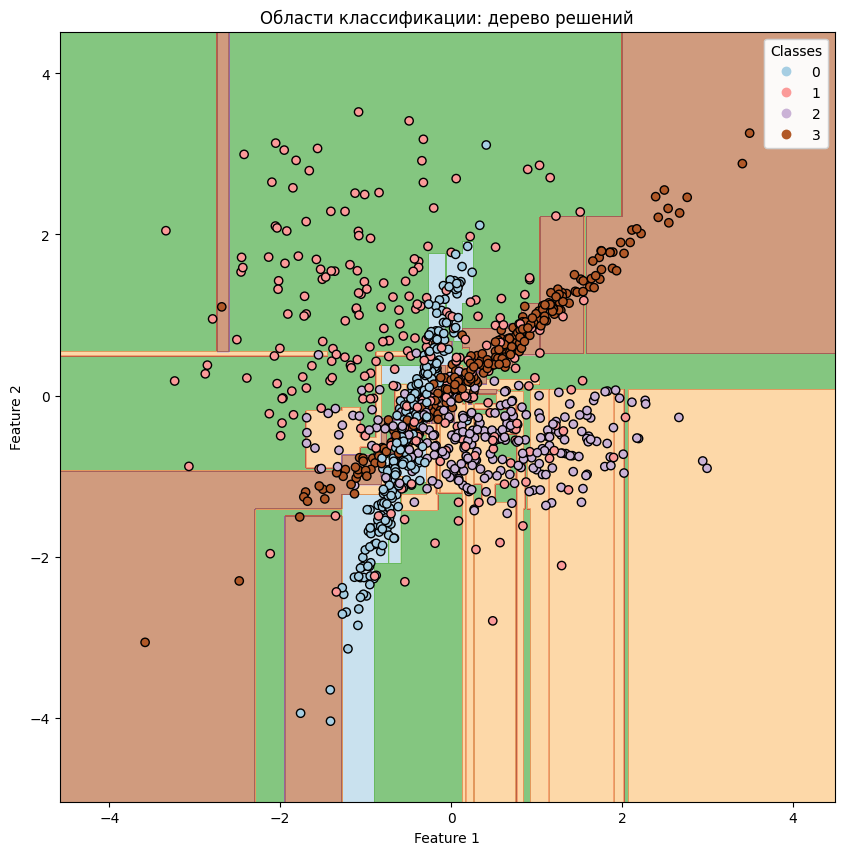

In [28]:
# Визуализация областей классификации
def plot_decision_boundaries(model, X, y, ax=None, title="Decision Boundaries"):
    if ax is None:
        ax = plt.gca()
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.6, cmap=plt.cm.Paired)
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, edgecolor="k", cmap=plt.cm.Paired)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_title(title)
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")
    legend = ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
    ax.add_artist(legend)

# Построение графика областей классификации
plt.figure(figsize=(10, 10))
plot_decision_boundaries(clf, X, y)
plt.title("Области классификации: дерево решений")
plt.show()

## Pre-pruning

In [20]:
clf_prepruned = DecisionTreeClassifier(max_depth=5, min_samples_split=10, random_state=42)
clf_prepruned.fit(X_train, y_train)

print(f"Accuracy (pre-pruned): {clf_prepruned.score(X_test, y_test):.2f}")

Accuracy (pre-pruned): 0.68


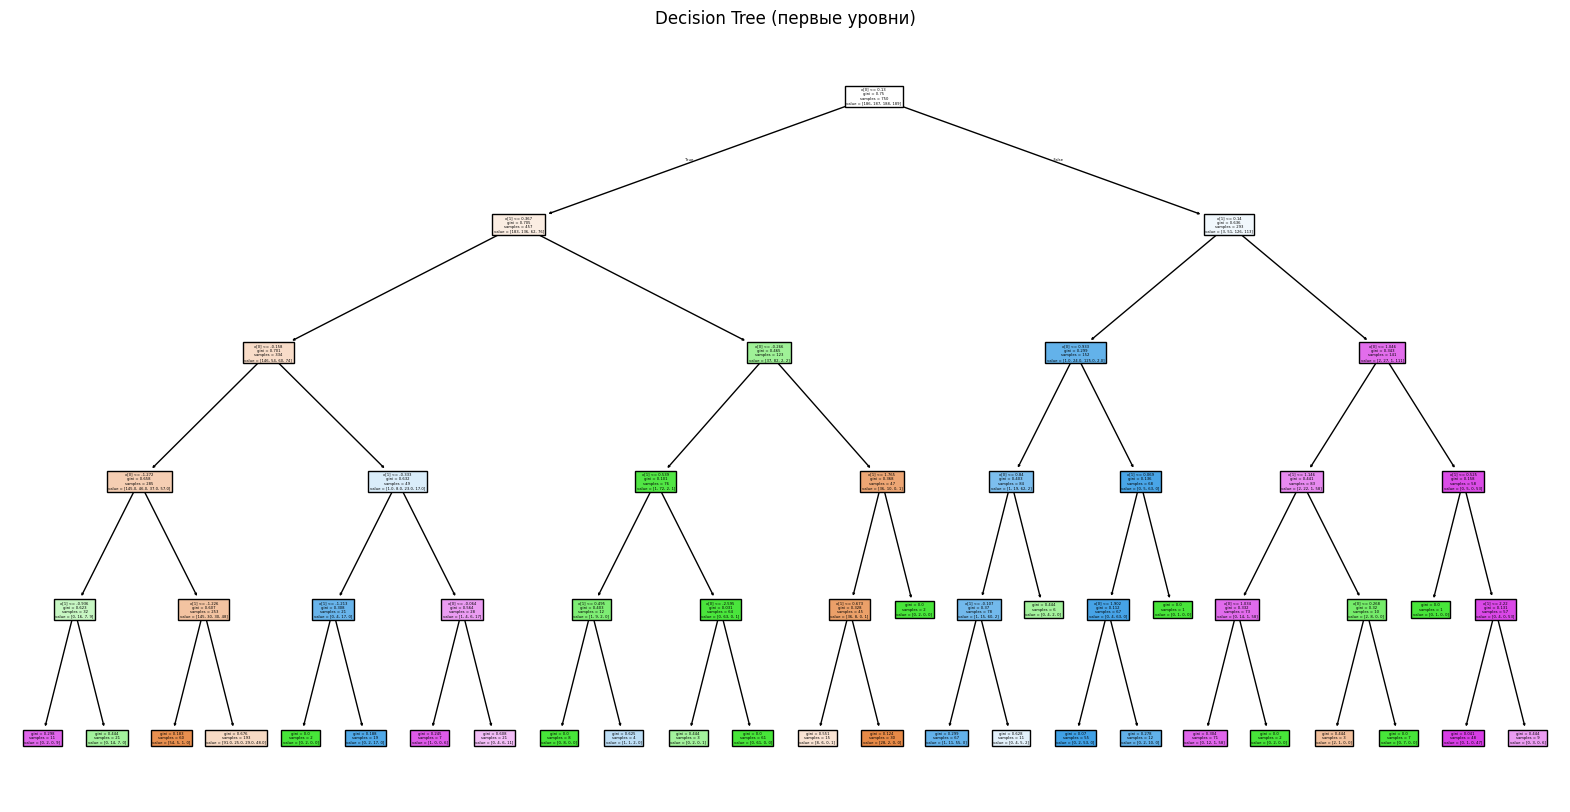

In [23]:
plt.figure(figsize=(20, 10))
plot_tree(clf_prepruned, filled=True)
plt.title("Decision Tree (первые уровни)")
plt.show()

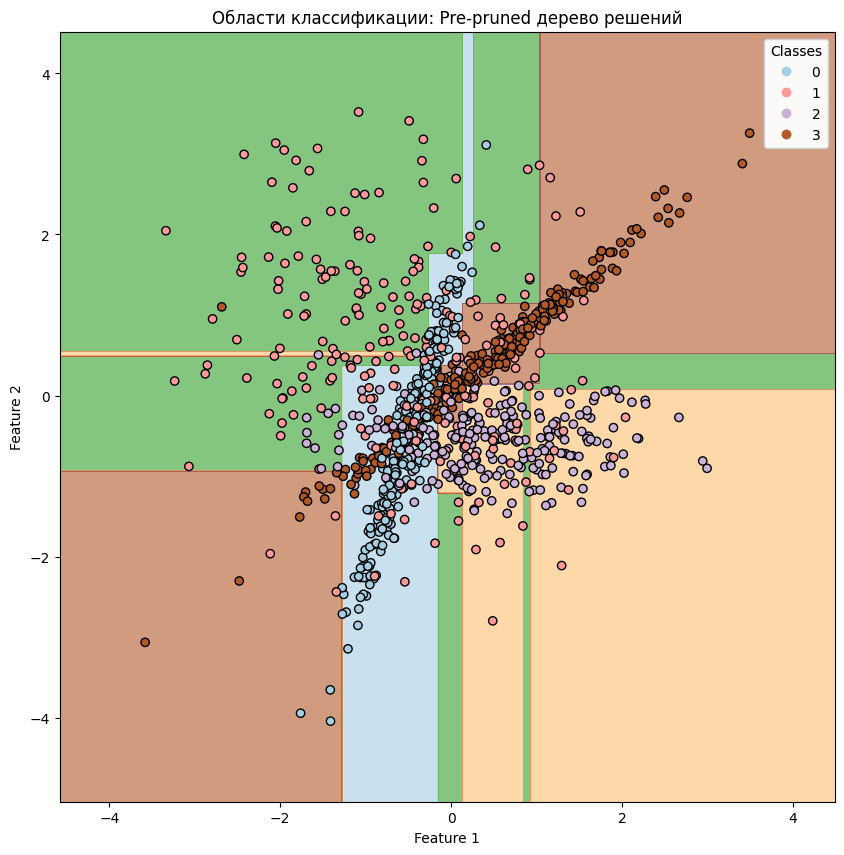

In [30]:
plt.figure(figsize=(10, 10))
plot_decision_boundaries(clf_prepruned, X, y)
plt.title("Области классификации: Pre-pruned дерево решений")
plt.show()

## Post-pruning

In [21]:
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

# Тестируем несколько деревьев с разными alpha
clfs = [DecisionTreeClassifier(random_state=42, ccp_alpha=alpha).fit(X_train, y_train) for alpha in ccp_alphas]

# Оцениваем на тесте
test_scores = [clf.score(X_test, y_test) for clf in clfs]

# Выбираем лучшее
best_index = np.argmax(test_scores)
best_alpha = ccp_alphas[best_index]
print(f"Best alpha: {best_alpha:.4f}, Accuracy: {test_scores[best_index]:.2f}")

Best alpha: 0.0070, Accuracy: 0.73


In [34]:
clf_postpruned = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha).fit(X_train, y_train)

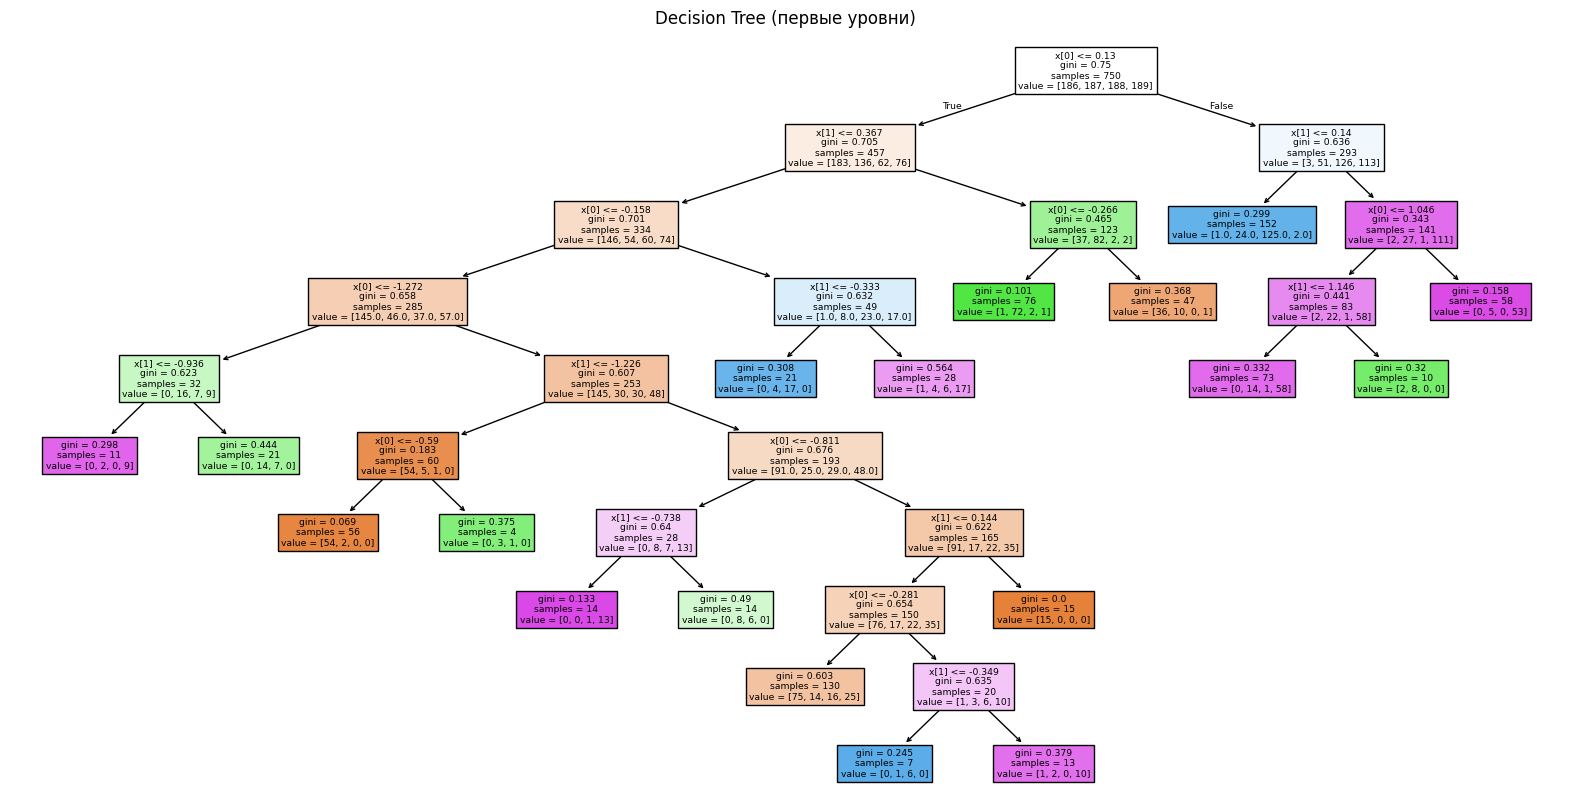

In [35]:
plt.figure(figsize=(20, 10))
plot_tree(clf_postpruned, filled=True)
plt.title("Decision Tree (первые уровни)")
plt.show()

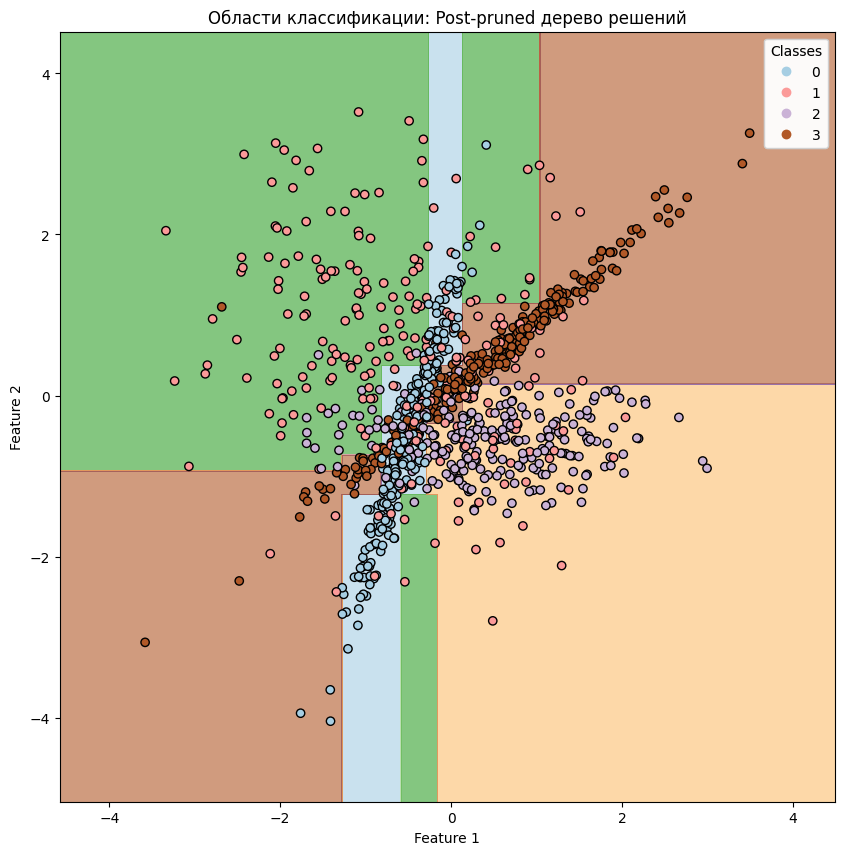

In [36]:
plt.figure(figsize=(10, 10))
plot_decision_boundaries(clf_postpruned, X, y)
plt.title("Области классификации: Post-pruned дерево решений")
plt.show()

## Поиск по сетке лучших гиперпараметров (поиск лучшей регуляризации)

In [45]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [1, 2, 5, 10, 15, None],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_leaf_nodes': [None, 10, 20, 30, 50]
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Best params: {grid_search.best_params_}")
print(f"Best accuracy: {grid_search.best_score_:.2f}")

Best params: {'max_depth': 10, 'max_leaf_nodes': 30, 'min_samples_leaf': 1}
Best accuracy: 0.74


In [46]:
best_clf = grid_search.best_estimator_

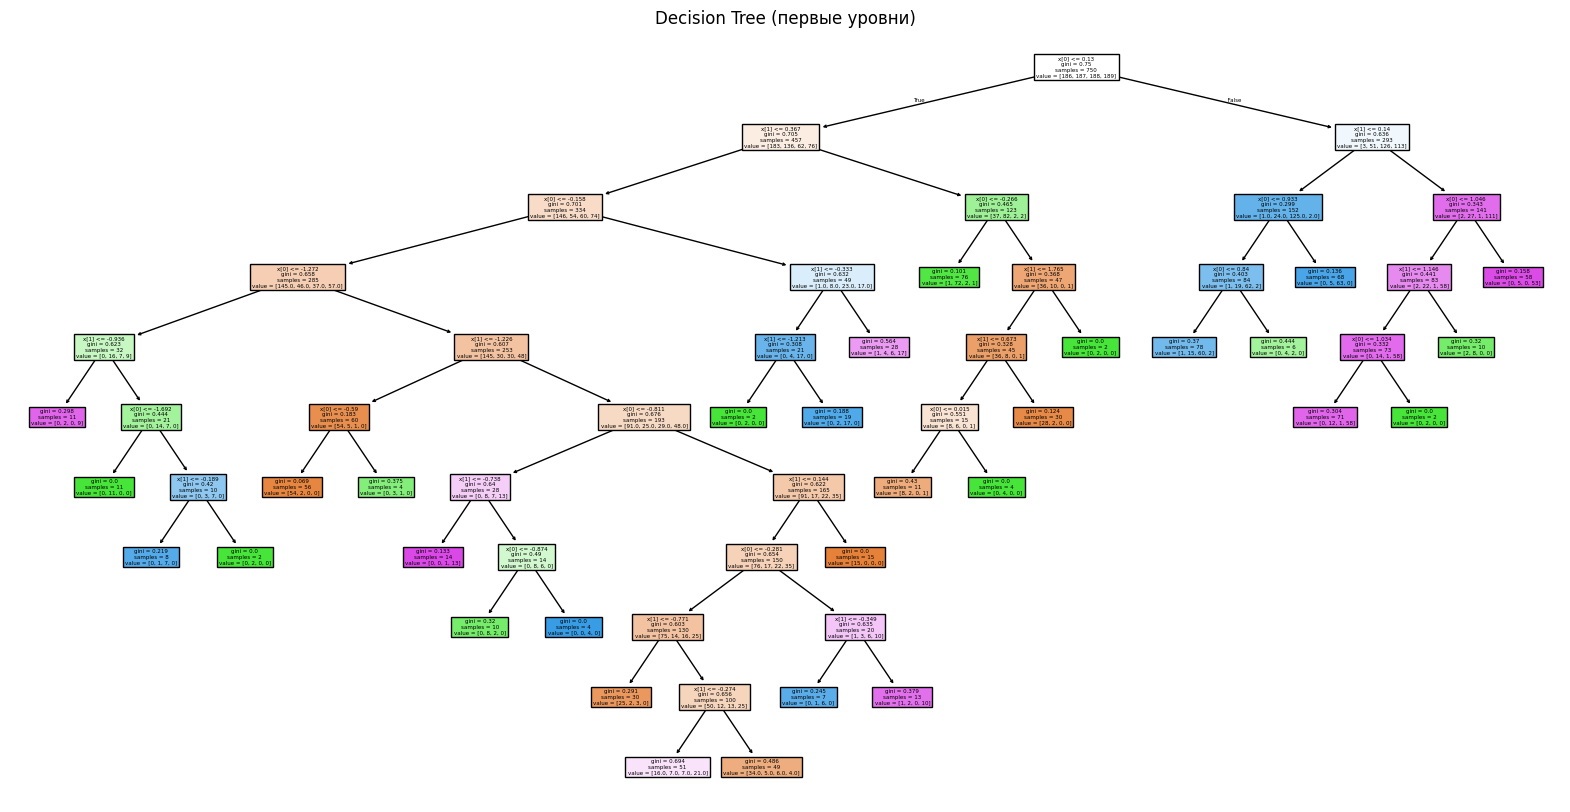

In [47]:
plt.figure(figsize=(20, 10))
plot_tree(best_clf, filled=True)
plt.title("Decision Tree (первые уровни)")
plt.show()

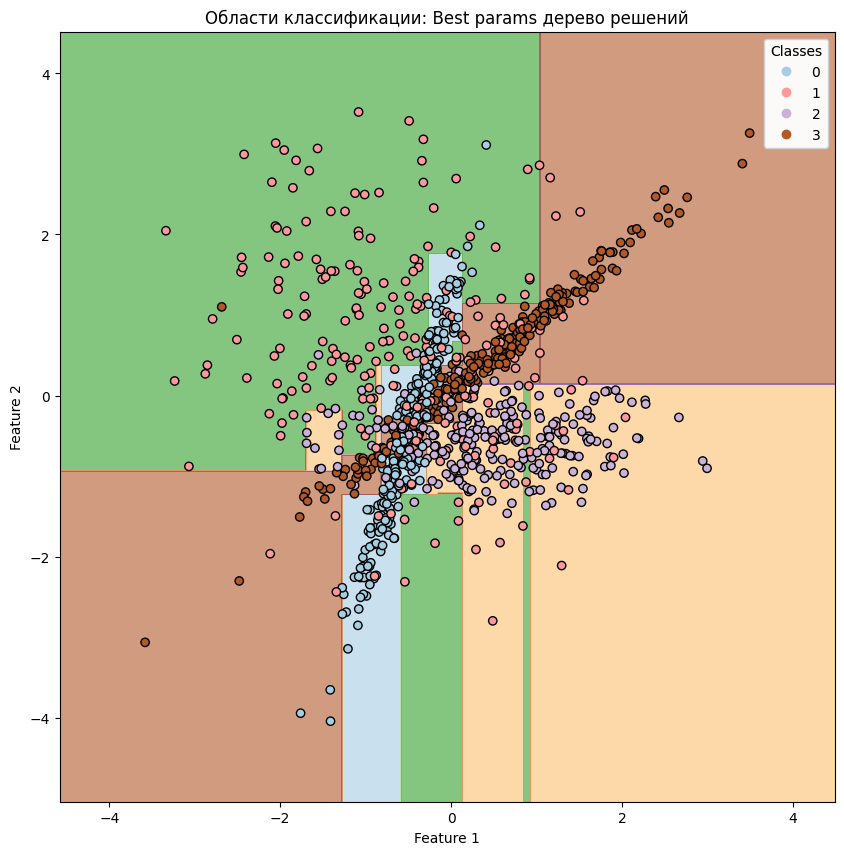

In [48]:
plt.figure(figsize=(10, 10))
plot_decision_boundaries(best_clf, X, y)
plt.title("Области классификации: Best params дерево решений")
plt.show()

## Работа с пропусками

In [59]:
import pandas as pd

# Создаем копию и добавим пропуски
X_missing = X.copy()
rng = np.random.RandomState(42)
missing_mask = rng.rand(*X_missing.shape) < 0.1
X_missing[missing_mask] = np.nan

# Обучим дерево на данных с пропущенными значениями после простой обработки
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X_missing)

X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_imputed, y, stratify=y, random_state=42)

clf_postpruned.fit(X_train_m, y_train_m)

print(f"Accuracy with missing values: {clf_postpruned.score(X_test_m, y_test_m):.2f}")

Accuracy with missing values: 0.63


In [56]:
pd.DataFrame(X_missing).sample(10, random_state=40)

,0,1
204,-0.175861,NaN
71,0.033544,0.778521
594,1.284577,-0.716192
672,2.174701,-0.528312
14,1.382030,NaN
64,NaN,0.053602
340,-0.686766,-1.184090
135,0.439899,0.302905
350,1.741449,NaN
976,-0.469268,-0.036559


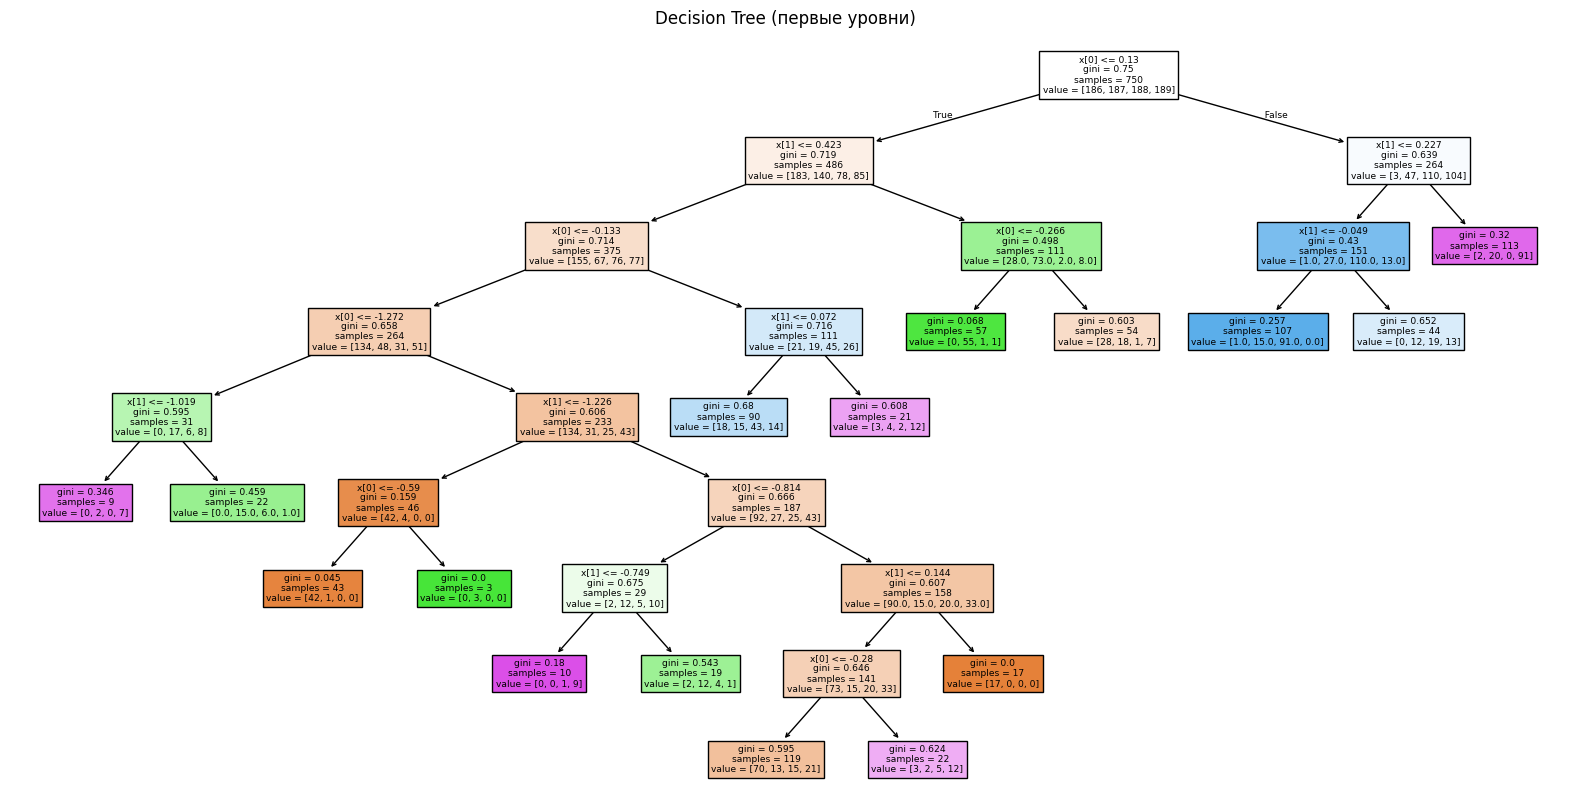

In [61]:
plt.figure(figsize=(20, 10))
plot_tree(clf_postpruned, filled=True)
plt.title("Decision Tree (первые уровни)")
plt.show()

## Неустойчивость дерева